Unsupervised Track Clustering <!-- omit in toc -->


**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc2_)    
- [Data Sourcing](#toc3_)    
  - [Fetch data from Wikipedia](#toc3_1_)    
  - [Load data from Ergast API](#toc3_2_)    
- [Data Preprocessing](#toc4_)    
  - [Text Preprocessing](#toc4_1_)    
- [Text Similarity Calculations](#toc5_)    
  - [Cosine similarity](#toc5_1_)    
  - [Jaccard Similarity](#toc5_2_)    
  - [Levenstein Distance](#toc5_3_)    
  - [Comparison](#toc5_4_)    
- [Fuzzy Join](#toc6_)    
- [Feature Engineering](#toc7_)    
  - [Extract years from date ranges](#toc7_1_)    
  - [Convert length to numeric](#toc7_2_)    
  - [One-hot encode categorical variables](#toc7_3_)    
  - [Missing data imputation](#toc7_4_)    
  - [Data Analysis and Visualization](#toc7_5_)    
- [Clustering](#toc8_)    
- [Conclusion](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports](#toc0_)

In [7]:
# Standard library imports
import itertools
import logging
import os
import re
import string
import sys
from collections import Counter
from typing import Callable, List, Tuple, Union

# Third-party library imports
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from fuzzywuzzy import fuzz
from Levenshtein import distance as lev_distance
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from wordcloud import WordCloud

# Local application imports
sys.path.append("../scripts")
from utilities import inspect_dataframe, remove_accents, load_ergast_csv, extract_years
from f1_data_fetcher import get_wiki_circuits

# Configurations

In [8]:
# NLTK downloads
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("punkt", quiet=True)

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# Initialize global variables
STOP_WORDS = set(stopwords.words("english"))
LEMMATIZER = WordNetLemmatizer()

# <a id='toc3_'></a>[Data Sourcing](#toc0_)

## <a id='toc3_1_'></a>[Fetch data from Wikipedia](#toc0_)

In [9]:
url = "https://en.wikipedia.org/wiki/List_of_Formula_One_circuits"
wiki_circuits = get_wiki_circuits(url)

if wiki_circuits is not None:
    print("Wikipedia Circuits")
    inspect_dataframe(wiki_circuits)
else:
    print("Failed to retrieve Wikipedia Circuits data")

2024-07-29 20:52:21,073 - INFO - Successfully fetched data from https://en.wikipedia.org/wiki/List_of_Formula_One_circuits
2024-07-29 20:52:21,313 - INFO - Successfully parsed HTML content. DataFrame shape: (77, 10)
2024-07-29 20:52:21,317 - INFO - Saved fetched data to ../data/wiki_circuits.csv


Wikipedia Circuits

DataFrame Shape: (77, 10)

Column Names: ['Circuit', 'Type', 'Direction', 'Location', 'Country', 'Last length used', 'Turns', 'Grands Prix', 'Season(s)', 'Grands Prix held']

Data Types:
 Circuit             object
Type                object
Direction           object
Location            object
Country             object
Last length used    object
Turns               object
Grands Prix         object
Season(s)           object
Grands Prix held    object
dtype: object

First 5 rows:
                          Circuit            Type  Direction    Location  \
0        Adelaide Street Circuit  Street circuit  Clockwise    Adelaide   
1               Ain-Diab Circuit    Road circuit  Clockwise  Casablanca   
2   Aintree Motor Racing Circuit    Road circuit  Clockwise     Aintree   
3          Albert Park Circuit *  Street circuit  Clockwise   Melbourne   
4  Algarve International Circuit    Race circuit  Clockwise    Portimão   

          Country     Last length used Tu

## <a id='toc3_2_'></a>[Load data from Ergast API](#toc0_)

The data have been pre-loaded from Kaggle as the API has been deprecated as of 2024. 

In [10]:
ergast_circuits = load_ergast_csv("../data/raw/circuits.csv")

Loaded 77 data entries from ../data/raw/circuits.csv


# <a id='toc4_'></a>[Data Preprocessing](#toc0_)

## <a id='toc4_1_'></a>[Text Preprocessing](#toc0_)

In [11]:
def preprocess_f1_circuit(
    text: str,
    regex_replacements: List[Tuple[str, str]],
    replace_punctuation: bool = True,
    keep_numbers: bool = True,
    remove_stopwords: bool = True,
    lemmatize: bool = True,
) -> str:
    """
    Preprocess Formula One circuit names.

    Args:
    text (str): The input text to preprocess.
    regex_replacements (List[Tuple[str, str]]): List of (regex_pattern, replacement) tuples.
    replace_punctuation (bool): Whether to replace punctuation with whitespace. Default is True.
    keep_numbers (bool): Whether to keep numbers. Default is True.
    remove_stopwords (bool): Whether to remove stopwords. Default is True.
    lemmatize (bool): Whether to lemmatize words. Default is True.

    Returns:
    str: The preprocessed text.
    """
    if not isinstance(text, str):
        return ""

    # Remove accents
    text = remove_accents(text)

    # Convert to lowercase and strip leading/trailing whitespaces
    text = text.lower().strip()

    # Apply regex-based replacements
    for pattern, replacement in regex_replacements:
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

    # Replace punctuation with whitespace
    if replace_punctuation:
        translator = str.maketrans(string.punctuation, " " * len(string.punctuation))
        text = text.translate(translator)

    # Keep or remove numbers
    if not keep_numbers:
        text = re.sub(r"\d+", "", text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    if remove_stopwords:
        tokens = [word for word in tokens if word not in STOP_WORDS]

    # Lemmatize
    if lemmatize:
        tokens = [LEMMATIZER.lemmatize(word) for word in tokens]

    # Join tokens back into a string
    return " ".join(tokens)


def standardize_circuit_names(names: List[str]) -> List[str]:
    """
    Standardize circuit names by applying common transformations.

    Args:
    names (List[str]): List of circuit names.

    Returns:
    List[str]: List of standardized circuit names.
    """
    regex_replacements = [
        (r"\b(international|internacional|internazionale)\b", "int"),
        (r"\b(circuit|track|raceway|speedway|autodrome|autodromo)\b", "track"),
        (r"\bgrand\s+prix\b", "gp"),
    ]

    return [
        preprocess_f1_circuit(name, regex_replacements=regex_replacements)
        for name in names
    ]

In [12]:
ergast_circuits["standardized_name"] = standardize_circuit_names(
    ergast_circuits["name"]
)
wiki_circuits["standardized_name"] = standardize_circuit_names(wiki_circuits["Circuit"])

## Visualizing preprocessed text

In [13]:
def plot_name_lengths(df: pd.DataFrame, original_col: str, modified_col: str):
    """
    Plot the distribution of name lengths before and after modification.

    Args:
    df (pd.DataFrame): The DataFrame containing the names
    original_col (str): The name of the column containing original names
    modified_col (str): The name of the column containing modified names
    """
    plt.figure(figsize=(12, 6))
    sns.histplot(
        df[original_col].str.len(), kde=True, color="blue", alpha=0.25, label="Original"
    )
    sns.histplot(
        df[modified_col].str.len(), kde=True, color="red", alpha=0.25, label="Modified"
    )
    plt.title("Distribution of Name Lengths")
    plt.xlabel("Length")
    plt.ylabel("Count")
    plt.legend()
    plt.show()


def create_wordcloud(df: pd.DataFrame, col: str):
    """
    Create a word cloud from the specified column.

    Args:
    df (pd.DataFrame): The DataFrame containing the names
    col (str): The name of the column to use for the word cloud
    """
    text = " ".join(df[col])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        text
    )

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud of {col}")
    plt.show()


def plot_most_common_words(df: pd.DataFrame, col: str, top_n: int = 20):
    """
    Plot the most common words in the specified column.

    Args:
    df (pd.DataFrame): The DataFrame containing the names
    col (str): The name of the column to analyze
    top_n (int): Number of top words to display
    """
    words = " ".join(df[col]).split()
    word_counts = Counter(words)
    top_words = dict(
        sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    )

    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(top_words.values()), y=list(top_words.keys()), orient="h")
    plt.title(f"Top {top_n} Most Common Words in {col}")
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.show()

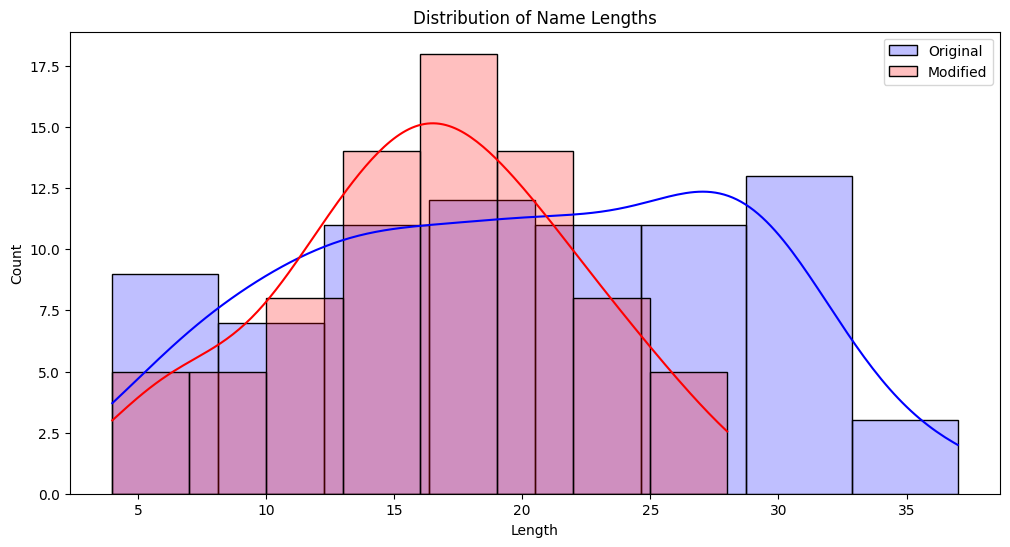

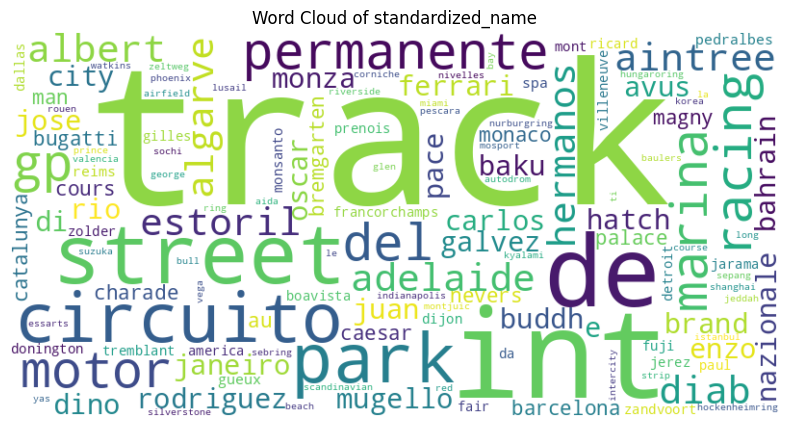

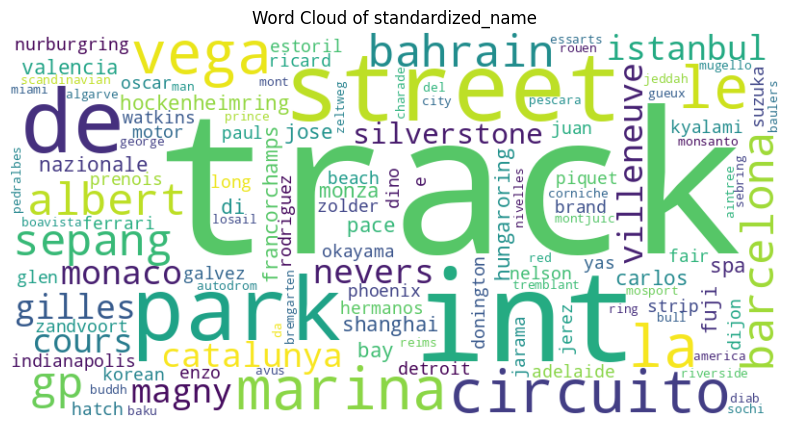

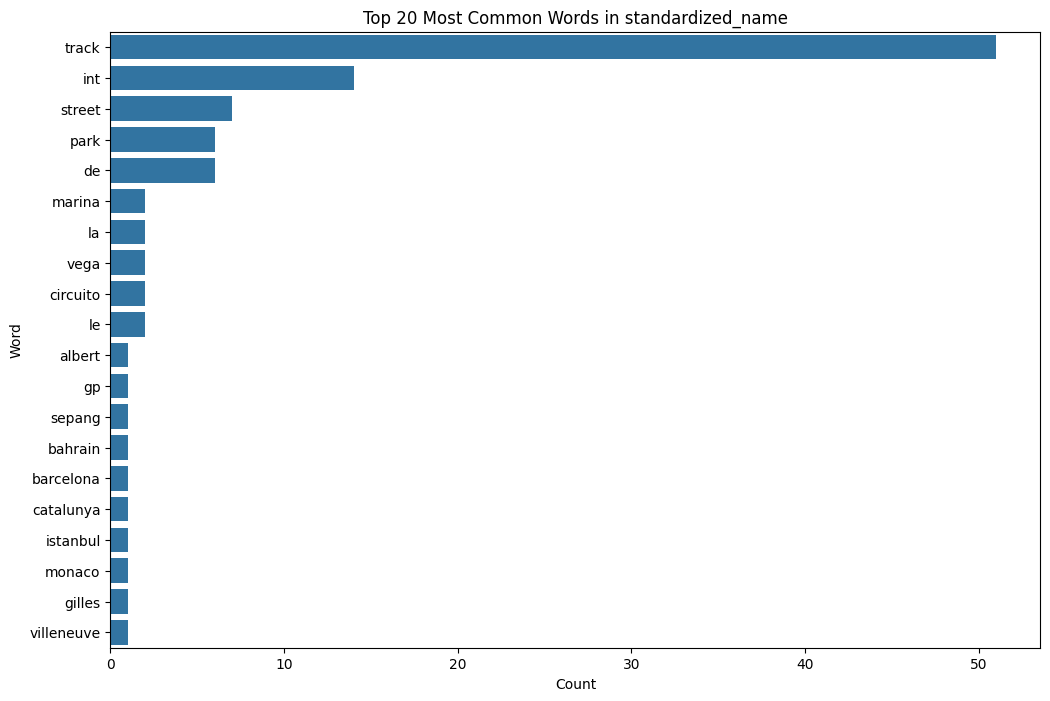

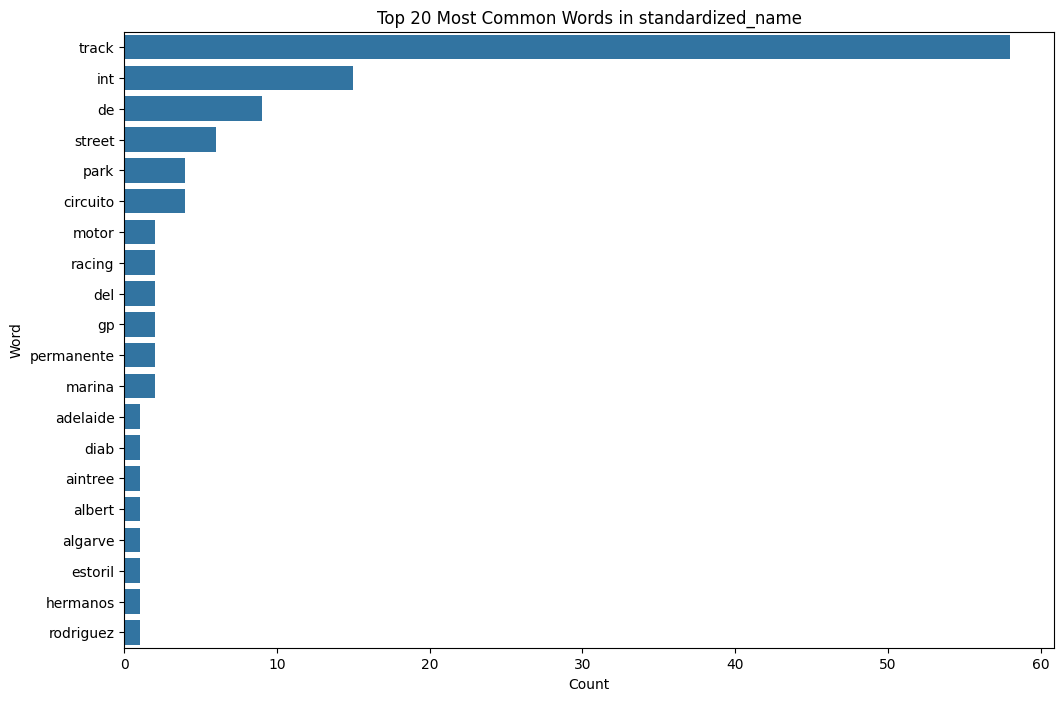

In [14]:
# Plot name lengths
plot_name_lengths(ergast_circuits, "name", "standardized_name")

# Create word clouds
create_wordcloud(wiki_circuits, "standardized_name")
create_wordcloud(ergast_circuits, "standardized_name")

# Plot most common words
plot_most_common_words(ergast_circuits, "standardized_name")
plot_most_common_words(wiki_circuits, "standardized_name")

# <a id='toc5_'></a>[Text Similarity Calculations](#toc0_)

Text Similarity Measures for Short Texts:

1. **Levenshtein Distance**: Counts single-character edits (insertions, deletions, substitutions) between strings. Best for minor spelling variations.
Example: "apple pie" vs "apple pi"
2. **Jaccard Similarity**: Measures overlap of unique words, ignoring order.
Formula: J(A,B) = |A ∩ B| / |A ∪ B|
Example: "apple pie" vs "pie apple"
3. **Cosine Similarity with TF-IDF**: Compares importance of terms across texts.
Process: Convert texts to TF-IDF vectors, calculate cosine similarity.
Example: "apple pie recipe" vs "recipe for apple pie"
4. **Word Embeddings**: Use pre-trained models (Word2Vec, GloVe) to capture semantic similarities.
Method: Average word vectors, then apply cosine similarity.
Example: "apple pie" vs "pie with apples"

For short texts with slight differences, combining TF-IDF/Cosine Similarity with Jaccard Similarity often yields good results.

## <a id='toc5_1_'></a>[Cosine similarity](#toc0_)

In [15]:
def calculate_cosine_similarity(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    text_column: str = "standardized_name",
    ngram_range: Tuple[int, int] = (1, 2),
    min_df: int = 1,
    max_df: float = 1.0,
) -> Tuple[np.ndarray, List[str]]:
    """
    Calculate cosine similarity between two dataframes based on a text column.

    Args:
    df1 (pd.DataFrame): First dataframe
    df2 (pd.DataFrame): Second dataframe
    text_column (str): Name of the column containing text to compare
    ngram_range (Tuple[int, int]): The lower and upper boundary of the range of n-values for different n-grams to be extracted
    min_df (int): Minimum number of documents a word must be present in to be kept
    max_df (float): Maximum proportion of documents a word can be present in to be kept

    Returns:
    Tuple[np.ndarray, List[str]]: Cosine similarity matrix and list of features (words) used
    """
    # Combine all unique preprocessed names for TF-IDF fitting
    all_names = pd.concat([df1[text_column], df2[text_column]]).unique()

    # Calculate TF-IDF
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, min_df=min_df, max_df=max_df)
    tfidf_matrix = vectorizer.fit_transform(all_names)

    # Split the TF-IDF matrix back to individual dataframes
    tfidf_df1 = tfidf_matrix[: len(df1)]
    tfidf_df2 = tfidf_matrix[len(df1) :]

    # Compute cosine similarity
    cosine_similarities = cosine_similarity(tfidf_df1, tfidf_df2)

    return cosine_similarities, vectorizer.get_feature_names_out()


def find_best_matches(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    cosine_similarities: np.ndarray,
    text_column: str = "standardized_name",
) -> pd.DataFrame:
    """
    Find the best matches based on cosine similarity and add them to the first dataframe.

    Args:
    df1 (pd.DataFrame): First dataframe (will be modified in-place)
    df2 (pd.DataFrame): Second dataframe
    cosine_similarities (np.ndarray): Cosine similarity matrix
    text_column (str): Name of the column containing text that was compared

    Returns:
    pd.DataFrame: Modified first dataframe with best matches and similarity scores
    """
    df1["best_cos_match"] = df1.index.map(
        lambda i: df2[text_column].iloc[cosine_similarities[i].argmax()]
    )
    df1["cos_similarity_score"] = df1.index.map(lambda i: cosine_similarities[i].max())
    return df1

In [16]:
cosine_similarities, features = calculate_cosine_similarity(
    ergast_circuits,
    wiki_circuits,
    text_column="standardized_name",
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.9,
)

ergast_circuits = find_best_matches(
    ergast_circuits, wiki_circuits, cosine_similarities, text_column="standardized_name"
)

# Display results
print("Top 5 matches:")
print(ergast_circuits[["name", "best_cos_match", "cos_similarity_score"]].head())

print("\nMost common features (words) used in similarity calculation:")
print(pd.Series(features).value_counts().head(10))

# Analyze similarity scores
print("\nSimilarity score statistics:")
print(ergast_circuits["cos_similarity_score"].describe())

# Find circuits with low similarity scores
low_similarity_threshold = 0.5
low_similarity_circuits = ergast_circuits[
    ergast_circuits["cos_similarity_score"] < low_similarity_threshold
]
print(f"\nCircuits with similarity score below {low_similarity_threshold}:")
print(low_similarity_circuits[["name", "best_cos_match", "cos_similarity_score"]])

Top 5 matches:
                             name              best_cos_match  \
0  Albert Park Grand Prix Circuit  aintree motor racing track   
1    Sepang International Circuit           albert park track   
2   Bahrain International Circuit           albert park track   
3  Circuit de Barcelona-Catalunya      track jose carlos pace   
4                   Istanbul Park              bugatti au man   

   cos_similarity_score  
0              0.585329  
1              0.267902  
2              0.267902  
3              0.221836  
4              0.719530  

Most common features (words) used in similarity calculation:
adelaide          1
pace              1
park zandvoort    1
park track        1
park gp           1
park              1
palace gp         1
palace            1
oscar juan        1
paul ricard       1
Name: count, dtype: int64

Similarity score statistics:
count    77.000000
mean      0.281501
std       0.254221
min       0.000000
25%       0.038939
50%       0.267902
75%   

## <a id='toc5_2_'></a>[Jaccard Similarity](#toc0_)

Measures overlap of unique words, ignoring order.
- Formula: J(A,B) = |A ∩ B| / |A ∪ B|
- Example: "apple pie" vs "pie apple" would be rated a similarity of 1 as they have the same unique words. 

In [17]:
def jaccard_similarity(str1: str, str2: str) -> float:
    """
    Calculate the Jaccard similarity between two strings.

    Args:
    str1 (str): First string
    str2 (str): Second string

    Returns:
    float: Jaccard similarity score
    """
    set1, set2 = set(str1.split()), set(str2.split())
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0


def calculate_jaccard_similarities(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    text_column: str = "standardized_name",
) -> np.ndarray:
    """
    Calculate Jaccard similarities between two dataframes.

    Args:
    df1 (pd.DataFrame): First dataframe
    df2 (pd.DataFrame): Second dataframe
    text_column (str): Name of the column containing text to compare

    Returns:
    np.ndarray: Jaccard similarity matrix
    """
    n_ergast, n_wiki = len(df1), len(df2)
    jaccard_similarities = np.zeros((n_ergast, n_wiki))

    for i in range(n_ergast):
        for j in range(n_wiki):
            jaccard_similarities[i, j] = jaccard_similarity(
                df1[text_column].iloc[i], df2[text_column].iloc[j]
            )

        # Print progress every 10%
        if i % (n_ergast // 10) == 0:
            print(f"Progress: {i / n_ergast * 100:.1f}% complete")

    return jaccard_similarities


def find_best_matches(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    similarity_matrix: np.ndarray,
    text_column: str = "standardized_name",
) -> pd.DataFrame:
    """
    Find the best matches based on similarity matrix and add them to the first dataframe.

    Args:
    df1 (pd.DataFrame): First dataframe (will be modified in-place)
    df2 (pd.DataFrame): Second dataframe
    similarity_matrix (np.ndarray): Similarity matrix
    text_column (str): Name of the column containing text that was compared

    Returns:
    pd.DataFrame: Modified first dataframe with best matches and similarity scores
    """
    df1["best_jac_match"] = df1.index.map(
        lambda i: df2[text_column].iloc[similarity_matrix[i].argmax()]
    )
    df1["jac_similarity_score"] = df1.index.map(lambda i: similarity_matrix[i].max())
    return df1

In [18]:
print("Calculating Jaccard similarities...")
jaccard_similarities = calculate_jaccard_similarities(
    ergast_circuits, wiki_circuits, text_column="standardized_name"
)

print("Finding best matches...")
ergast_circuits = find_best_matches(
    ergast_circuits,
    wiki_circuits,
    jaccard_similarities,
    text_column="standardized_name",
)

# Display results
print("\nTop 5 matches:")
print(ergast_circuits[["name", "best_jac_match", "jac_similarity_score"]].head())

# Analyze similarity scores
print("\nJaccard similarity score statistics:")
print(ergast_circuits["jac_similarity_score"].describe())

# Find circuits with low similarity scores
low_similarity_threshold = 0.5
low_similarity_circuits = ergast_circuits[
    ergast_circuits["jac_similarity_score"] < low_similarity_threshold
]
print(f"\nCircuits with Jaccard similarity score below {low_similarity_threshold}:")
print(low_similarity_circuits[["name", "best_jac_match", "jac_similarity_score"]])

# Compare Jaccard and Cosine similarities
if "cos_similarity_score" in ergast_circuits.columns:
    print("\nCorrelation between Jaccard and Cosine similarity scores:")
    correlation = ergast_circuits["jac_similarity_score"].corr(
        ergast_circuits["cos_similarity_score"]
    )
    print(f"Correlation coefficient: {correlation:.4f}")

    print("\nCircuits with large discrepancy between Jaccard and Cosine scores:")
    discrepancy = abs(
        ergast_circuits["jac_similarity_score"]
        - ergast_circuits["cos_similarity_score"]
    )
    large_discrepancy = ergast_circuits[
        discrepancy > discrepancy.mean() + 2 * discrepancy.std()
    ]
    print(
        large_discrepancy[
            ["name", "best_jac_match", "jac_similarity_score", "cos_similarity_score"]
        ]
    )

Calculating Jaccard similarities...
Progress: 0.0% complete
Progress: 9.1% complete
Progress: 18.2% complete
Progress: 27.3% complete
Progress: 36.4% complete
Progress: 45.5% complete
Progress: 54.5% complete
Progress: 63.6% complete
Progress: 72.7% complete
Progress: 81.8% complete
Progress: 90.9% complete
Finding best matches...

Top 5 matches:
                             name                best_jac_match  \
0  Albert Park Grand Prix Circuit             albert park track   
1    Sepang International Circuit              sepang int track   
2   Bahrain International Circuit             bahrain int track   
3  Circuit de Barcelona-Catalunya  track de barcelona catalunya   
4                   Istanbul Park       intercity istanbul park   

   jac_similarity_score  
0              0.750000  
1              1.000000  
2              1.000000  
3              1.000000  
4              0.666667  

Jaccard similarity score statistics:
count    77.000000
mean      0.833983
std       0.2418

## <a id='toc5_3_'></a>[Levenstein Distance](#toc0_)

In [19]:
def levenshtein_similarity(str1: str, str2: str) -> float:
    """
    Calculate the Levenshtein similarity between two strings.

    Args:
        str1 (str): First string
        str2 (str): Second string

    Returns:
        float: Similarity score between 0 and 1
    """
    if not isinstance(str1, str) or not isinstance(str2, str):
        raise ValueError("Both inputs must be strings")

    if not str1 and not str2:
        return 1.0
    elif not str1 or not str2:
        return 0.0

    distance = lev_distance(str1, str2)
    max_len = max(len(str1), len(str2))
    return 1 - (distance / max_len)


def calculate_levenshtein_similarities(
    df1: pd.DataFrame, df2: pd.DataFrame, col_name: str
) -> np.ndarray:
    """
    Calculate Levenshtein similarities between two DataFrames.

    Args:
        df1 (pd.DataFrame): First DataFrame
        df2 (pd.DataFrame): Second DataFrame
        col_name (str): Name of the column to compare

    Returns:
        np.ndarray: 2D array of similarity scores
    """
    n1, n2 = len(df1), len(df2)
    similarities = np.zeros((n1, n2))

    for i, j in itertools.product(range(n1), range(n2)):
        similarities[i, j] = levenshtein_similarity(
            df1[col_name].iloc[i], df2[col_name].iloc[j]
        )

        # Print progress every 10%
        if (i * n2 + j + 1) % (n1 * n2 // 10) == 0:
            print(f"Progress: {(i * n2 + j + 1) / (n1 * n2) * 100:.1f}% complete")

    return similarities


def find_best_matches(
    df1: pd.DataFrame, df2: pd.DataFrame, similarities: np.ndarray, col_name: str
) -> Tuple[List[str], List[float]]:
    """
    Find the best matches based on Levenshtein similarities.

    Args:
        df1 (pd.DataFrame): First DataFrame
        df2 (pd.DataFrame): Second DataFrame
        similarities (np.ndarray): 2D array of similarity scores
        col_name (str): Name of the column to compare

    Returns:
        Tuple[List[str], List[float]]: Best matches and their similarity scores
    """
    best_matches = df2[col_name].iloc[np.argmax(similarities, axis=1)].tolist()
    best_scores = np.max(similarities, axis=1).tolist()
    return best_matches, best_scores

In [20]:
print("Calculating Levenshtein similarities...")
similarities = calculate_levenshtein_similarities(
    ergast_circuits, wiki_circuits, "standardized_name"
)

print("Finding best matches...")
best_matches, best_scores = find_best_matches(
    ergast_circuits, wiki_circuits, similarities, "standardized_name"
)

ergast_circuits["best_lev_match"] = best_matches
ergast_circuits["lev_sim_score"] = best_scores

# Display results
print("\nTop 5 matches:")
print(ergast_circuits[["name", "best_lev_match", "lev_sim_score"]].head())

# Analyze similarity scores
print("\nLevenshtein similarity score statistics:")
print(ergast_circuits["lev_sim_score"].describe())

# Find circuits with low similarity scores
low_similarity_threshold = 0.5
low_similarity_circuits = ergast_circuits[
    ergast_circuits["lev_sim_score"] < low_similarity_threshold
]
print(f"\nCircuits with Levenshtein similarity score below {low_similarity_threshold}:")
print(low_similarity_circuits[["name", "best_lev_match", "lev_sim_score"]])

# Compare Levenshtein with other similarity measures
for measure in ["cos_similarity_score", "jac_similarity_score"]:
    if measure in ergast_circuits.columns:
        print(f"\nCorrelation between Levenshtein and {measure}:")
        correlation = ergast_circuits["lev_sim_score"].corr(ergast_circuits[measure])
        print(f"Correlation coefficient: {correlation:.4f}")

        print(f"\nCircuits with large discrepancy between Levenshtein and {measure}:")
        discrepancy = abs(ergast_circuits["lev_sim_score"] - ergast_circuits[measure])
        large_discrepancy = ergast_circuits[
            discrepancy > discrepancy.mean() + 2 * discrepancy.std()
        ]
        print(large_discrepancy[["name", "best_lev_match", "lev_sim_score", measure]])

Calculating Levenshtein similarities...
Progress: 10.0% complete
Progress: 20.0% complete
Progress: 30.0% complete
Progress: 39.9% complete
Progress: 49.9% complete
Progress: 59.9% complete
Progress: 69.9% complete
Progress: 79.9% complete
Progress: 89.9% complete
Progress: 99.8% complete
Finding best matches...

Top 5 matches:
                             name                best_lev_match  lev_sim_score
0  Albert Park Grand Prix Circuit             albert park track       0.850000
1    Sepang International Circuit              sepang int track       1.000000
2   Bahrain International Circuit             bahrain int track       1.000000
3  Circuit de Barcelona-Catalunya  track de barcelona catalunya       1.000000
4                   Istanbul Park       intercity istanbul park       0.565217

Levenshtein similarity score statistics:
count    77.000000
mean      0.850410
std       0.219093
min       0.285714
25%       0.684211
50%       1.000000
75%       1.000000
max       1.000000
Na

## <a id='toc5_4_'></a>[Comparison](#toc0_)

In [21]:
ergast_circuits[
    [
        "name",
        "best_cos_match",
        "cos_similarity_score",
        "best_jac_match",
        "jac_similarity_score",
        "best_lev_match",
        "lev_sim_score",
    ]
].describe()

,cos_similarity_score,jac_similarity_score,lev_sim_score
count,77.000000,77.000000,77.000000
mean,0.281501,0.833983,0.850410
std,0.254221,0.241832,0.219093
min,0.000000,0.250000,0.285714
25%,0.038939,0.666667,0.684211
50%,0.267902,1.000000,1.000000
75%,0.438907,1.000000,1.000000
max,0.837518,1.000000,1.000000


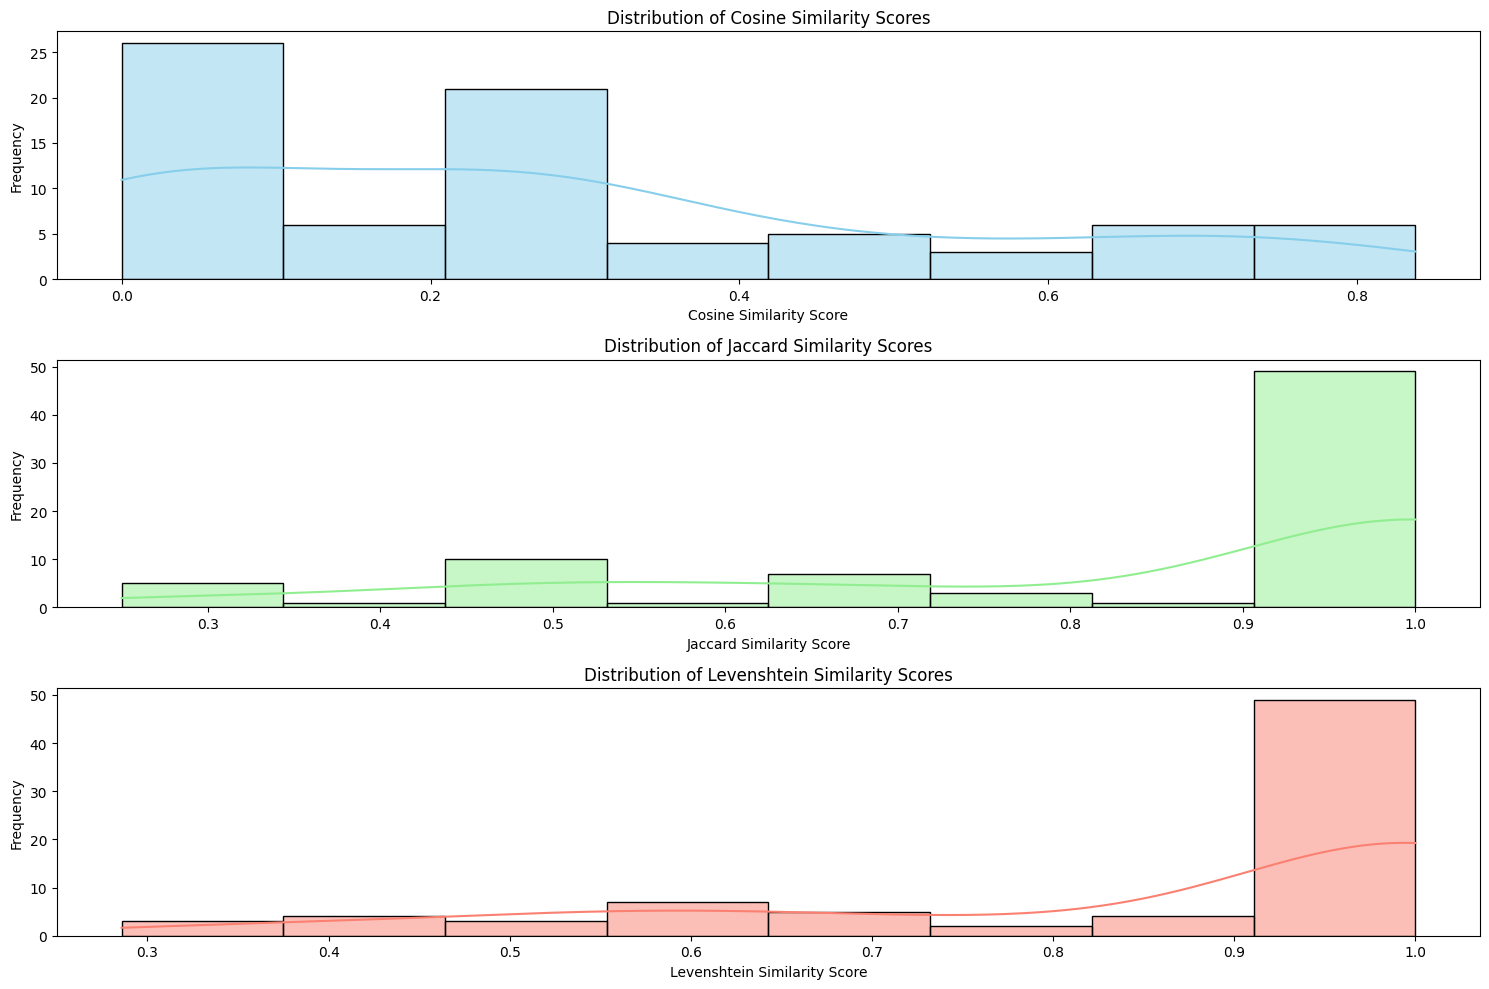

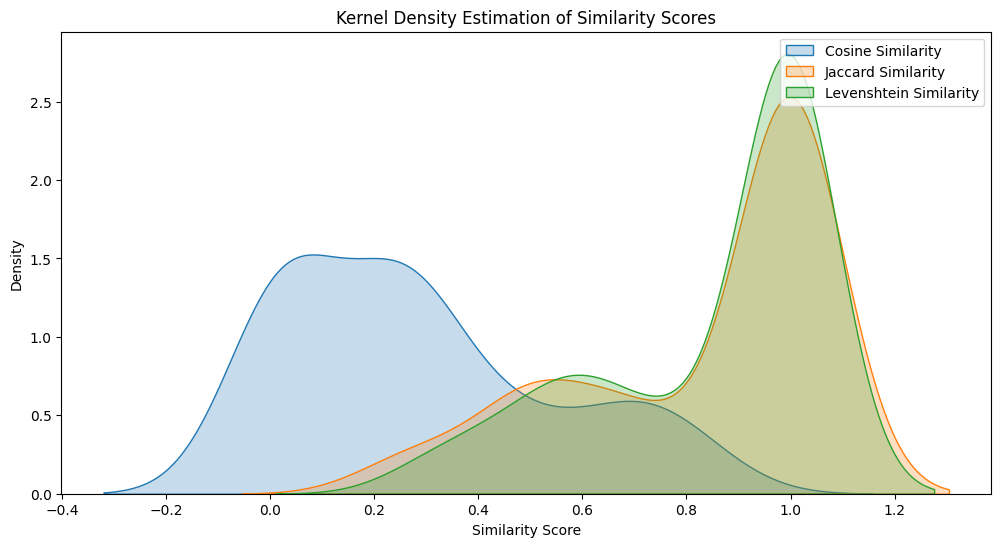

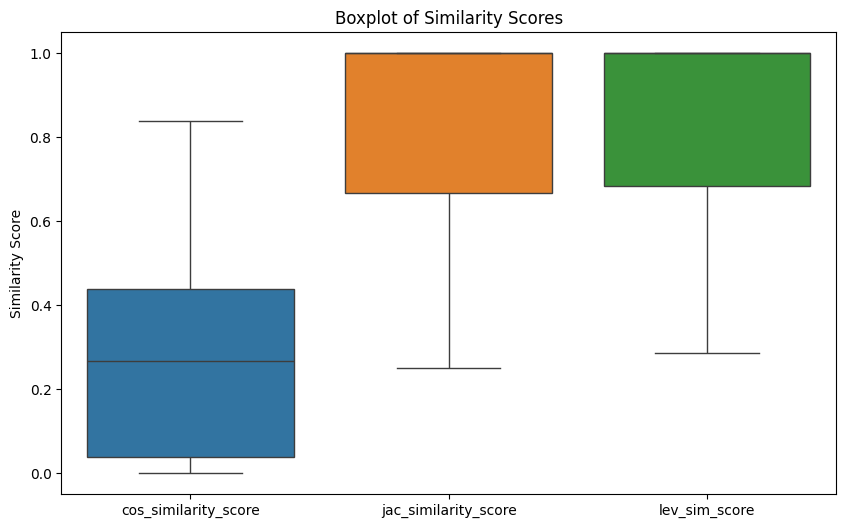

In [22]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Histogram and KDE for Cosine Similarity
plt.subplot(3, 1, 1)
sns.histplot(ergast_circuits["cos_similarity_score"], kde=True, color="skyblue")
plt.title("Distribution of Cosine Similarity Scores")
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")

# Histogram and KDE for Jaccard Similarity
plt.subplot(3, 1, 2)
sns.histplot(ergast_circuits["jac_similarity_score"], kde=True, color="lightgreen")
plt.title("Distribution of Jaccard Similarity Scores")
plt.xlabel("Jaccard Similarity Score")
plt.ylabel("Frequency")

# Histogram and KDE for Levenshtein Similarity
plt.subplot(3, 1, 3)
sns.histplot(ergast_circuits["lev_sim_score"], kde=True, color="salmon")
plt.title("Distribution of Levenshtein Similarity Scores")
plt.xlabel("Levenshtein Similarity Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Kernel Density Estimation (KDE) plot for all similarity measures
plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=ergast_circuits["cos_similarity_score"], fill=True, label="Cosine Similarity"
)
sns.kdeplot(
    data=ergast_circuits["jac_similarity_score"], fill=True, label="Jaccard Similarity"
)
sns.kdeplot(
    data=ergast_circuits["lev_sim_score"], fill=True, label="Levenshtein Similarity"
)
plt.title("Kernel Density Estimation of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Density")
plt.legend()
plt.show()

# Boxplot to compare distributions
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=ergast_circuits[
        ["cos_similarity_score", "jac_similarity_score", "lev_sim_score"]
    ]
)
plt.title("Boxplot of Similarity Scores")
plt.ylabel("Similarity Score")
plt.show()

We can see that Jaccard similarity performs the best. This makes sense given that there is a lot of overlap in the names of the circuits as they use common words and roots of words (e.g., international, circuit, park ). This demonstrates that matching terms (words) between the texts are more critical than the frequency or order of words. Also, because terms are not repeated in the names of circuits, it is intuitive that term frequency would not add valuable information. 

# <a id='toc6_'></a>[Fuzzy Join](#toc0_)

In [23]:
def fuzzy_join(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    column: str,
    threshold: int = 80,
    similarity_metric: Callable[[str, str], int] = fuzz.token_sort_ratio,
) -> pd.DataFrame:
    """
    Perform a fuzzy join between two DataFrames based on a specified column.

    Args:
    df1 (pd.DataFrame): First DataFrame
    df2 (pd.DataFrame): Second DataFrame
    column (str): Name of the column to join on
    threshold (int): Minimum similarity score to consider a match (0-100)
    similarity_metric (Callable): Function to calculate similarity score

    Returns:
    pd.DataFrame: Joined DataFrame
    """

    def find_best_match(name: str, candidates: List[str]) -> Tuple[str, int]:
        best_match = max(candidates, key=lambda x: similarity_metric(name, x))
        score = similarity_metric(name, best_match)
        return (best_match, score) if score >= threshold else (None, score)

    # Create a dictionary of best matches
    matches = {}
    for name in df1[column]:
        best_match, score = find_best_match(name, df2[column].tolist())
        matches[name] = {"best_match": best_match, "similarity_score": score}

    # Create a DataFrame from the matches
    match_df = pd.DataFrame.from_dict(matches, orient="index")

    # Join the match results back to df1
    result = df1.join(match_df, on=column)

    # Merge with df2 based on the best match
    result = result.merge(
        df2,
        left_on="best_match",
        right_on=column,
        how="left",
        suffixes=("_df1", "_df2"),
    )

    return result

In [26]:
joined_circuits = fuzzy_join(
    ergast_circuits, wiki_circuits, "standardized_name", threshold=75
)

# Display results before filtering
print("Before filtering:")
print(
    joined_circuits[["standardized_name_df1", "best_match", "similarity_score"]].head(
        10
    )
)

# Analyze match quality before filtering
print("\nMatch quality summary before filtering:")
print(joined_circuits["similarity_score"].describe())

# Filter out low-quality matches
quality_threshold = 75
filtered_joined_circuits = joined_circuits[
    joined_circuits["similarity_score"] >= quality_threshold
]

# Display results after filtering
print("\nAfter filtering (similarity score >= {}):".format(quality_threshold))
print(
    filtered_joined_circuits[
        ["standardized_name_df1", "best_match", "similarity_score"]
    ].head(10)
)

# Analyze match quality after filtering
print("\nMatch quality summary after filtering:")
print(filtered_joined_circuits["similarity_score"].describe())

# Check how many matches were removed
removed_count = len(joined_circuits) - len(filtered_joined_circuits)
print(f"\nNumber of low-quality matches removed: {removed_count}")

# Display removed matches
removed_matches = joined_circuits[
    joined_circuits["similarity_score"] < quality_threshold
]
print("\nRemoved low-quality matches:")
print(removed_matches[["standardized_name_df1", "best_match", "similarity_score"]])

Before filtering:
          standardized_name_df1                    best_match  \
0          albert park gp track             albert park track   
1              sepang int track              sepang int track   
2             bahrain int track             bahrain int track   
3  track de barcelona catalunya  track de barcelona catalunya   
4                 istanbul park                          None   
5               track de monaco               track de monaco   
6       track gilles villeneuve       track gilles villeneuve   
7   track de nevers magny cours   track de nevers magny cours   
8             silverstone track             silverstone track   
9                hockenheimring                hockenheimring   

   similarity_score  
0                92  
1               100  
2               100  
3               100  
4                72  
5               100  
6               100  
7               100  
8               100  
9               100  

Match quality summary b

In [27]:
drop = [
    "standardized_name_df1",
    "standardized_name_df2",
    "best_jac_match",
    "jac_similarity_score",
    "best_lev_match",
    "lev_sim_score",
    "Location",
    "Country",
    "best_cos_match",
    "cos_similarity_score",
    "similarity_score",
    "url",
    "Circuit",
    "circuitRef",
    "best_match",
]

filtered_joined_circuits = filtered_joined_circuits.drop(columns=drop)
filtered_joined_circuits.to_csv("../data/filtered_joined_circuits.csv", index=False)

# <a id='toc7_'></a>[Feature Engineering](#toc0_)

In [28]:
# Ensure we're working with a copy of the DataFrame
joined_circuits_copy = filtered_joined_circuits.copy()


In [29]:
def preprocess_f1_circuits(df):

    # 1. Extract numeric values (km) from 'Last length used'
    df["track_length_km"] = (
        df["Last length used (km)"].astype(str).str.extract("(\d+\.\d+)").astype(float)
    )

    # 2. Apply extract_years function to 'Extracted_Seasons'
    df["Extracted_Seasons"] = df["Extracted_Seasons"].apply(extract_years)

    # 3. Create feature for number of seasons
    df["num_seasons"] = df["Extracted_Seasons"].apply(len)

    # 4. Create feature for first and last season
    df["first_season"] = df["Extracted_Seasons"].apply(
        lambda x: min(x) if x else np.nan
    )
    df["last_season"] = df["Extracted_Seasons"].apply(lambda x: max(x) if x else np.nan)

    # 5. Extract number of different Grand Prix types
    df["num_gp_types"] = df["Grands Prix"].str.count(",") + 1

    # 6. Identify features for different types of preprocessing
    numeric_features = [
        "lat",
        "lng",
        "alt",
        "track_length_km",
        "Turns",
        "Grands Prix held",
        "num_seasons",
        "first_season",
        "last_season",
        "num_gp_types",
    ]
    categorical_features = ["Type", "Direction", "country"]

    # 7. Create preprocessing pipelines
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    # 8. Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    # 9. Fit and transform the data
    X_processed = preprocessor.fit_transform(df)

    # 10. Create a new dataframe with processed features
    feature_names = (
        numeric_features
        + preprocessor.named_transformers_["cat"]
        .named_steps["onehot"]
        .get_feature_names(categorical_features)
        .tolist()
    )

    X_processed_df = pd.DataFrame(X_processed, columns=feature_names, index=df.index)

    return X_processed_df, preprocessor

In [ ]:
# Preprocess the data
X_processed, preprocessor = preprocess_f1_circuits(joined_circuits_copy)

# Display the first few rows of the processed data
print(X_processed.head())

# Display info about the processed dataset
print(X_processed.info())

# Optional: Save the processed data
X_processed.to_csv("processed_f1_circuits.csv", index=False)

## <a id='toc7_1_'></a>[Extract years from date ranges](#toc0_)

In [ ]:
def extract_years(date_range: Union[str, float]) -> List[int]:
    """
    Extract years from a given date range string.

    Args:
    date_range (str or float): A string representing a range of years or seasons, or a float (for NaN values).

    Returns:
    List[int]: A list of integers representing all years in the range.
    """
    if pd.isna(date_range):
        return []

    if not isinstance(date_range, str):
        return []

    years = []
    clean_range = re.sub(r"\[.*?\]", "", date_range)
    parts = [part.strip() for part in clean_range.split(",")]

    for part in parts:
        if "–" in part:
            start, end = part.split("–")
            start_year = int(re.search(r"\d{4}", start).group())
            end_year = int(re.search(r"\d{4}", end).group())
            years.extend(range(start_year, end_year + 1))
        else:
            year = int(re.search(r"\d{4}", part).group())
            years.append(year)

    return sorted(set(years))

In [ ]:
# Check if the 'Season(s)' column exists
if "Season(s)" in filtered_joined_circuits.columns:
    # Apply the extract_years function
    filtered_joined_circuits.loc[:, "Extracted_Seasons"] = filtered_joined_circuits[
        "Season(s)"
    ].apply(extract_years)
    # Display the first few rows to verify
    print(filtered_joined_circuits[["Season(s)", "Extracted_Seasons"]].head())
    filtered_joined_circuits = filtered_joined_circuits.drop(columns=["Season(s)"])
else:
    print("The 'Season(s)' column is not present in the DataFrame.")
    print("Available columns:", filtered_joined_circuits.columns.tolist())

## <a id='toc7_2_'></a>[Convert length to numeric](#toc0_)

In [ ]:
filtered_joined_circuits["Last length used (km)"] = filtered_joined_circuits[
    "Last length used"
].apply(lambda x: float(re.sub(r"\s*km\s*\(\d+\.\d+\s*mi\)", "", x)))
filtered_joined_circuits = filtered_joined_circuits.drop(columns=["Last length used"])

## <a id='toc7_3_'></a>[One-hot encode categorical variables](#toc0_)

In [ ]:
OneHotEncoder(sparse_output=False).fit_transform(fuzzy_joined_df[["Type"]])

## <a id='toc7_4_'></a>[Missing data imputation](#toc0_)

## <a id='toc7_5_'></a>[Data Analysis and Visualization](#toc0_)

# <a id='toc8_'></a>[Clustering](#toc0_)

# <a id='toc9_'></a>[Conclusion](#toc0_)